# Evaluate models after training

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.3.0


In [2]:
model_list = ['ResNet50_20_80e_GSP1.0', 'InceptionV3_20_100e_GSP1.0_nopp']
labels_list = ['ResNet50', 'InceptionV3']

## Plot model comparison

In [3]:
def plot_val_accs(model_list, labels_list, tune_epoch_val=None, outfile=None):
    
    # initialize plot
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)
    
    # loop over models
    for model, label in zip(model_list, labels_list):
        # import information
        metrics_df = pd.read_csv(f'../models/{model}_metrics.csv')
        x_vals = np.arange(1, metrics_df.shape[0]+1)
        acc = metrics_df['val_acc'].values
        t5_acc = metrics_df['val_t5'].values
        
        # plot information
        axes[0].plot(x_vals, acc, '+-', label=label)
        axes[1].plot(x_vals, t5_acc, '+-', label=label)

    # tidy
    for ax in axes:
        ax.legend()
        ax.grid(ls='--', c='C7')
        if tune_epoch_val:
            ax.axvline(tune_epoch_val, c='C7', ls='--')
        
    axes[0].set_ylabel('Accuracy')
    axes[1].set_ylabel('Top 5 Accuracy')
        
    axes[0].set_title('Accuracy Comparison')
    axes[1].set_title('Top 5 Accuracy Comparison')    
    
    axes[1].set_ylabel('Epoch')
    
    if outfile:  
        plt.savefig(f'../figures/{outfile}.png', dpi=400)
    plt.show()

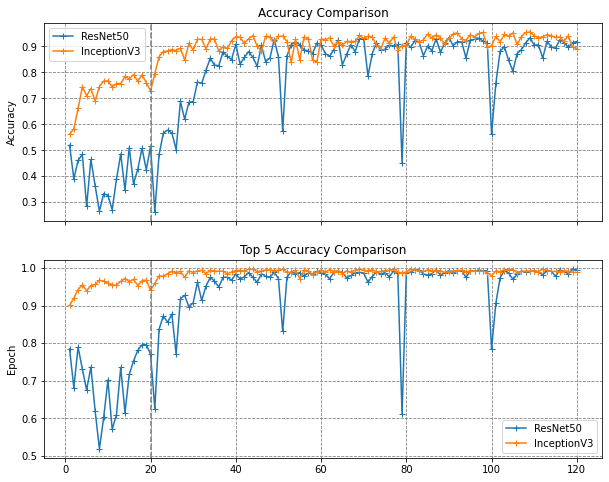

In [4]:
plot_val_accs(model_list, labels_list, tune_epoch_val=20)#, outfile='compare_model_evolution')

## Get final epoch metrics

In [5]:
def get_final_metrics(model):
    metrics_df = pd.read_csv(f'../models/{model}_metrics.csv')
    print(f'Model: {model_list[0]}')
    return metrics_df.iloc[-1]

In [6]:
get_final_metrics(model_list[0])

Model: ResNet50_20_80e_GSP1.0


acc         0.963535
val_acc     0.919001
loss        0.100131
val_loss    0.321740
t5          0.998848
val_t5      0.993944
Name: 119, dtype: float64

## Get test metrics

In [7]:
def load_weights(weights_file):
    try: 
        with open(weights_file, 'rb') as fp:
            weights = pickle.load(fp)
            return weights

    except: 
        print("Unable to load weights file")

In [30]:
print(model_list)

['ResNet50_20_80e_GSP1.0', 'InceptionV3_20_100e_GSP1.0_nopp']


In [28]:
model = model_list[1]
class_weight_dict = load_weights('../data/gsp15_class_weight_dict.p')

data_path = '../data/gsp15_ttv/'
class_names = ['Aloe_Vera', 'Asparagus_Fern', 'Baby_Rubber_Plant', 'Boston_Fern', 'Easter_Lily', 
           'Fiddle_Leaf_Fig', 'Jade_Plant', 'Monstera','Parlor_Palm', 'Peace_Lily', 'Pothos', 
           'Rubber_Plant', 'Snake_Plant', 'Spider_Plant', 'Umbrella_Tree']

img_width, img_height = 224, 224
batch_size = 32

test_data_dir = f'{data_path}/test'
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input) 
test_generator = test_datagen.flow_from_directory( 
    test_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    classes=class_names,
    class_mode='categorical',
    seed = 2020,
    shuffle = False) 

Unable to load weights file
Found 1321 images belonging to 15 classes.


In [29]:
path = f'../models/{model}'
model = tf.keras.models.load_model(f'{path}_model.h5')
model.load_weights(f'{path}_weights.h5')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_6 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              52429824  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 15)                15375     
Total params: 74,247,983
Trainable params: 74,213,551
Non-trainable params: 34,432
_________________________________________________________________


In [30]:
loss, acc, t5_acc = model.evaluate(test_generator)

print(f'Test accuracy is: {acc}')
print(f'Test top 5 accuracy is: {t5_acc}')

42/42 [==============================] - 26s 616ms/step - loss: 0.4649 - accuracy: 0.8910 - top_k_categorical_accuracy: 0.9886
Test accuracy is: 0.8909916877746582
Test top 5 accuracy is: 0.9886449575424194


## Plot confusion matrix

In [97]:
y_pred = model.predict_classes(test_generator)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
normalized_cm = sklearn.preprocessing.normalize(cm, norm="l1")

In [98]:
# https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if count:
        group_counts = ["{0:0.2f}%\n".format(value*100) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:0.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    hm = sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18)
    hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18)
    
    if xyplotlabels:
        plt.ylabel('True label', size=20)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


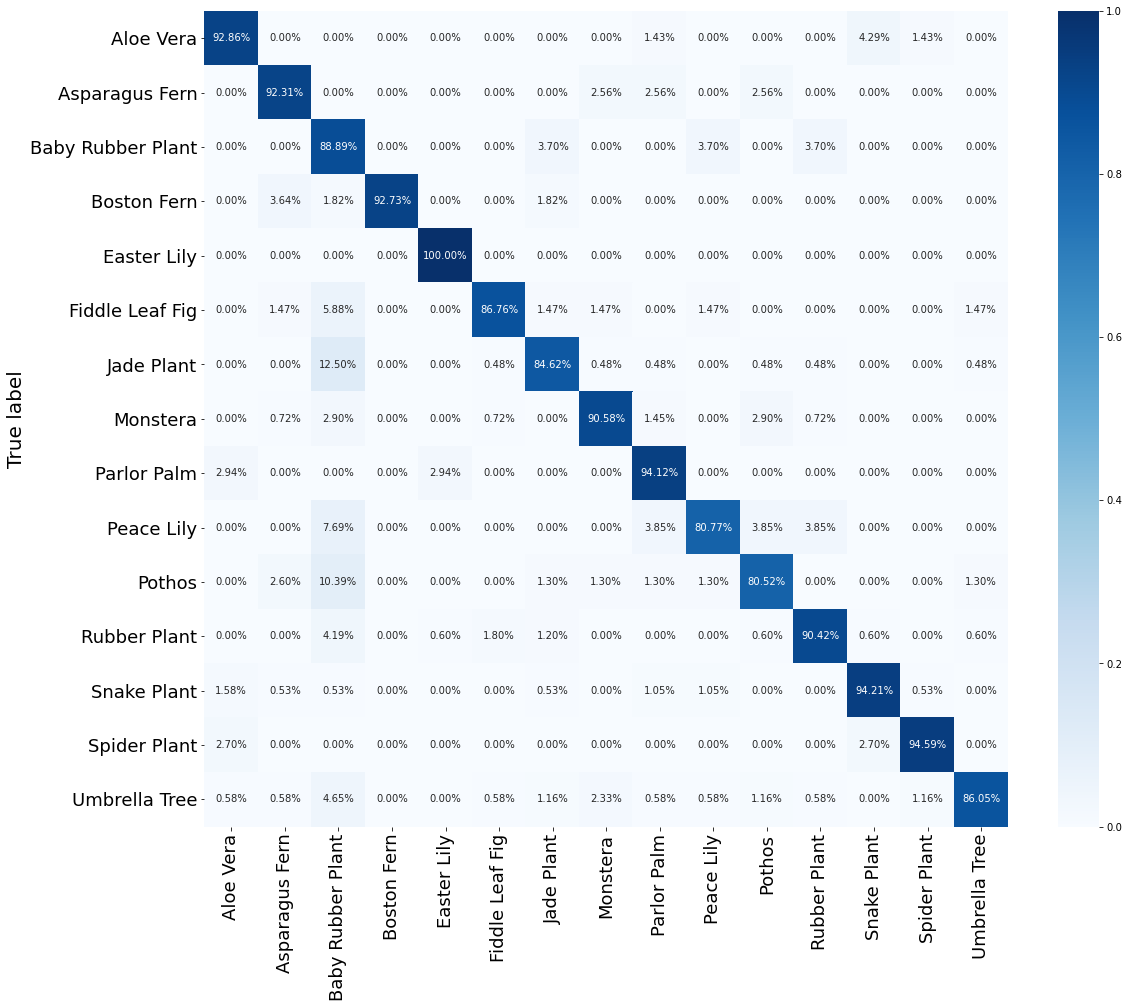

In [99]:
import seaborn as sns

spacer = lambda x: x.replace('_', ' ') # define spacer function
classes_spaced = list(map(spacer, class_names)) # apply to replace _ with a space

make_confusion_matrix(normalized_cm, 
                      categories=classes_spaced,
                      figsize=(18,15),
                      percent=False)

In [96]:
# confusion_matrix(validation_generator.classes, y_pred)
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

print('Classification Report')
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report
                   precision    recall  f1-score   support

        Aloe_Vera       0.92      0.93      0.92        70
   Asparagus_Fern       0.82      0.92      0.87        39
Baby_Rubber_Plant       0.28      0.89      0.43        27
      Boston_Fern       1.00      0.93      0.96        55
      Easter_Lily       0.87      1.00      0.93        13
  Fiddle_Leaf_Fig       0.91      0.87      0.89        68
       Jade_Plant       0.95      0.85      0.90       208
         Monstera       0.94      0.91      0.92       138
      Parlor_Palm       0.76      0.94      0.84        34
       Peace_Lily       0.78      0.81      0.79        26
           Pothos       0.86      0.81      0.83        77
     Rubber_Plant       0.97      0.90      0.93       167
      Snake_Plant       0.97      0.94      0.96       190
     Spider_Plant       0.90      0.95      0.92        37
    Umbrella_Tree       0.97      0.86      0.91       172

         accuracy               